In [64]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Hidden Markov Model 

In [159]:
class ModelHMM:
    
    """ A class used to learn parameters of a Hidden Markov Model using Baum Welch algorithm """
    
    def __init__(self, A, B, data, freeze_B): 
        
        """ Instantiate a model instance with: 
        
        A: (num_hidden*num_hidden) array representing transition probabilities between hidden states  
        B: (num_hidden*num_obs) array representing emission probabilities conditioned on each hidden state 
        data: list of observations 
        freeze_B: list of Booleans of len=num_hidden indicating whether emission probabilities should be fixed 
            (e.g. [True, False, False] means to freeze only the first hidden state's)
                
        """
        
        # initialize HMM parameters 
        self.A = A 
        self.B = B
        self.num_hidden, self.num_obs = B.shape
        assert len(freeze_B) == self.num_hidden
        self.freeze_B = freeze_B
        
        # initialize data parameters 
        self.data = data 
        self.T = len(data)
        
        # initialize additional attributes used in learning the parameters of an HMM 
        self.forwards = np.zeros((self.num_hidden, self.T))
        self.backwards = np.zeros((self.num_hidden, self.T))
        self.coefs = np.zeros(self.T) # coefs used to rescale forward/backward probas for numerical stability 
        self.gammas = np.zeros((self.num_hidden, self.T))
        self.ixs = np.zeros((self.num_hidden, self.num_hidden, self.T-1))
        
    def forward_pass(self, pi):
        
        """ Implements the forward algorithm to compute forward probabilities 
        (note: to prevent numerical underflow probabilities are normalized with scaling factors 'coefs') """
        
        # define initial probabilities pi if not provided 
        if pi is None: 
            if not np.any(self.gammas):
                # use gammas at t=0 if estimates already exist 
                pi = self.gammas[:,0]
            else:
                # in case of cold start, assume all hidden states are equally probable 
                pi = np.full(shape=(self.num_hidden), fill_value=1./self.num_hidden)
        
        # compute first time step 
        self.forwards[:,0] = np.multiply(pi, self.B[:, self.data[0]-1]) # because 0-index 
        self.coefs[0] = 1 / self.forwards[:,0].sum()
        self.forwards[:,0] = self.coefs[0] * self.forwards[:,0]

        # iterate over rest of time steps 
        for t in range(1, self.T): 
            self.forwards[:,t] = np.multiply(self.A @ self.forwards[:,t-1], self.B[:, self.data[t]-1])
            self.coefs[t] = 1 / self.forwards[:,t].sum()
            self.forwards[:,t] = self.coefs[t] * self.forwards[:,t]
            
    def backward_pass(self): 
        
        """ Implements backward algorithm to compute backward probabilities 
        (note: uses 'coefs' computed in forward step to normalize probabilities to prevent underflow) """
        
        # compute last time step 
        self.backwards[:, -1] = 1
        self.backwards[:, -1] = self.coefs[-1] * self.backwards[:, -1]

        # iterate backward through rest of time steps 
        for t in reversed(range(self.T-1)):
            self.backwards[:,t] = np.multiply(self.A @ self.backwards[:,t+1], self.B[:, self.data[t+1]-1])
            self.backwards[:,t] = self.coefs[t] * self.backwards[:,t]
            
    def e_step(self, pi=None):
        
        """ Expectation step of the Baum-Welch EM algorithm. Uses forward and backward probabilities to compute: 
            - gammas: (num_hidden*T) array representing probabilities of being in a hidden state j at time t
            - ixs: (num_hidden*num_hidden*T-1) array representing probabilities of transitioning 
            from hidden state i at time t to hidden state j at time t+1 """
        
        self.forward_pass(pi)
        self.backward_pass()
        
        # compute ixs 
        for t in range(self.T-1):
            for i in range(self.num_hidden):
                for j in range(self.num_hidden): 
                    self.ixs[i,j,t] = self.forwards[i,t] * self.A[i,j] * \
                        self.B[j, self.data[t+1]-1] * self.backwards[j,t+1]
        
        # compute gammas 
        for t in range(self.T):
            self.gammas[:,t] = np.multiply(self.forwards[:,t], self.backwards[:,t])
    
    def m_step(self): 

        """ Maximization step of the Baum-Welch EM algorithm. Uses gammas and ixs to update 
        transition probabilities A and emission probabilities B. """

        # re-estimate A 
        for i in range(self.num_hidden):
            for j in range(self.num_hidden):
                self.A[i,j] = self.ixs[i,j,:].sum() / self.ixs[i,:,:].sum()        
                
        # re-estimate B 
        for j in range(self.num_hidden):
            if self.freeze_B[j]: # if one die's proba is fixed don't update it 
                pass 
            else:
                for k in range(self.num_obs):
                    obs_mask = np.array([datum == k+1 for datum in self.data])
                    self.B[j,k] = (self.gammas[j,:] * obs_mask).sum() / self.gammas[j,:].sum()
                    
    def compute_ll(self):
        
        """ Compute loglikelihood. Based on Stamp (2018) this is equivalent to the negative sum of 
            log normalizing coefficients computed earlier """
        
        log_likelihood = -1 * np.sum(np.log(self.coefs))
        
        return log_likelihood
                
    def train(self, num_iter, initial_pi):
        
        """ Runs Baum-Welch algo for num_iter times to update model parameters, store parameters at each 
        time step to output for analysis """
        
        # initialize dictionaries to hold params 
        transition_probs, emission_probs, log_likelihoods = {}, {}, {} 
        transition_probs[0] = self.A.copy()
        emission_probs[0] = self.B.copy()
        log_likelihoods[0] = self.compute_ll()
        
        # run EM for num_iter iterations 
        for m in range(1, num_iter+1): 
            self.e_step(initial_pi) # fix initial_pi in this model because we know casino started w/ fair die
            self.m_step() 
            transition_probs[m] = self.A.copy() 
            emission_probs[m] = self.B.copy() 
            log_likelihoods[m] = self.compute_ll()
            
        return transition_probs, emission_probs, log_likelihoods

# Fit Model 

In [160]:
# load data 
with open("sequence.txt", "r") as f:
    data = eval(f.read())

## 2-Dice Model

In [161]:
# define model 
A = np.array([[.5, .5], 
              [.5, .5]])
B = np.array([[1./6, 1./6, 1./6, 1./6, 1./6, 1./6], 
              [1./6, 1./6, 1./6, 1./6, 1./6, 1./6]])
initial_pi = np.array([1., 0.])
freeze_B = [True, False]

model_2d = ModelHMM(A, B, data, freeze_B)
transition_probs_2d, emission_probs_2d, log_likelihoods_2d = model_2d.train(num_iter=500, initial_pi=initial_pi)
print(model_2d.A)
print(model_2d.B)

/Users/garyng/anaconda3/envs/py37base/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


[[1.07900541e-07 9.99999892e-01]
 [1.35826038e-03 9.98641740e-01]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.2688393  0.13944835 0.13635905 0.13727043 0.1364907  0.18159218]]


In [162]:
# transition probabilities 
pd.DataFrame(model_2d.A, index=['Fair', 'Loaded'], columns=['Fair', 'Loaded'])

,Fair,Loaded
Fair,1.079005e-07,1.000000
Loaded,1.358260e-03,0.998642


In [163]:
# emission probabilities 
pd.DataFrame(model_2d.B, index=['Fair', 'Loaded'], columns=np.arange(1,7))

,1,2,3,4,5,6
Fair,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
Loaded,0.268839,0.139448,0.136359,0.137270,0.136491,0.181592


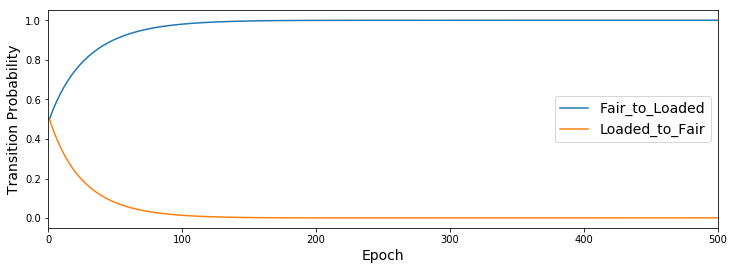

In [164]:
tprob_2d = pd.DataFrame({
    'Fair_to_Loaded': [v[0,1] for (k,v) in transition_probs_2d.items()], 
    'Loaded_to_Fair': [v[1,0] for (k,v) in transition_probs_2d.items()]}) 
tprob_2d.plot(figsize=(12,4))
plt.ylabel('Transition Probability', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14);

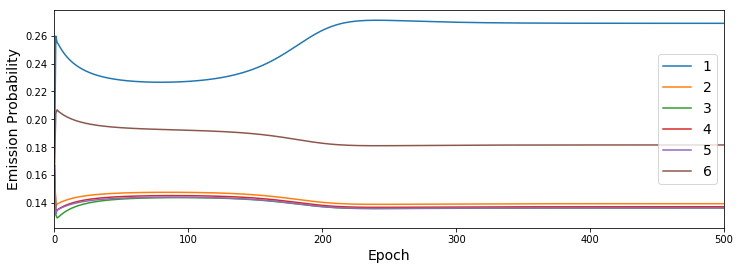

In [165]:
eprob_2d = pd.DataFrame({
    1: [v[1,0] for (k,v) in emission_probs_2d.items()],
    2: [v[1,1] for (k,v) in emission_probs_2d.items()],
    3: [v[1,2] for (k,v) in emission_probs_2d.items()],
    4: [v[1,3] for (k,v) in emission_probs_2d.items()],    
    5: [v[1,4] for (k,v) in emission_probs_2d.items()],       
    6: [v[1,5] for (k,v) in emission_probs_2d.items()]})

eprob_2d.plot(kind='line', figsize=(12,4))
plt.ylabel('Emission Probability', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14);

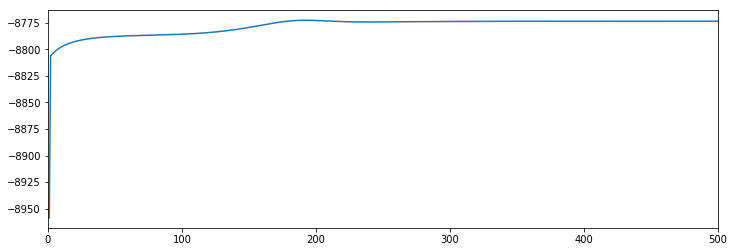

In [170]:
pd.Series(log_likelihoods_2d).plot(figsize=(12,4))

In [188]:
pd.Series(log_likelihoods_2d).iloc[1:].max()

-8772.57624050561

In [178]:
log_likelihoods

-8773.508822198515

## 3-Dice Model Results

In [171]:
# three dice 
A = np.array([[.34, .33, .33], 
              [.33, .34, .33],
              [.33, .33, .34]])
B = np.array([[1./6, 1./6, 1./6, 1./6, 1./6, 1./6], 
              [2./7, 1./7, 1./7, 1./7, 1./7, 1./7],
              [1./7, 1./7, 1./7, 1./7, 1./7, 2./7]])
initial_pi = np.array([1., 0., 0.])
freeze_B = [True, False, False]

model_3d = ModelHMM(A, B, data, freeze_B)
transition_probs_3d, emission_probs_3d, log_likelihoods_3d = model_3d.train(num_iter=1000, initial_pi=initial_pi)
print(model_3d.A)
print(model_3d.B)

/Users/garyng/anaconda3/envs/py37base/lib/python3.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log


[[9.14886303e-31 1.20576359e-06 9.99998794e-01]
 [8.58156544e-04 8.15496036e-01 1.83645808e-01]
 [3.86552056e-04 6.67898584e-02 9.32823590e-01]]
[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.34981346 0.13447876 0.15645463 0.12734667 0.13106073 0.10084575]
 [0.2094931  0.14653762 0.12708889 0.14673757 0.14311802 0.22702479]]


In [172]:
# transition probabilities 
pd.DataFrame(model_3d.A, index=['Fair', 'Loaded1', 'Loaded2'], columns=['Fair', 'Loaded1', 'Loaded2'])

,Fair,Loaded1,Loaded2
Fair,9.148863e-31,0.000001,0.999999
Loaded1,8.581565e-04,0.815496,0.183646
Loaded2,3.865521e-04,0.066790,0.932824


In [173]:
# emission probabilities 
pd.DataFrame(model_3d.B, index=['Fair', 'Loaded1', 'Loaded2'], columns=np.arange(1,7))

,1,2,3,4,5,6
Fair,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
Loaded1,0.349813,0.134479,0.156455,0.127347,0.131061,0.100846
Loaded2,0.209493,0.146538,0.127089,0.146738,0.143118,0.227025


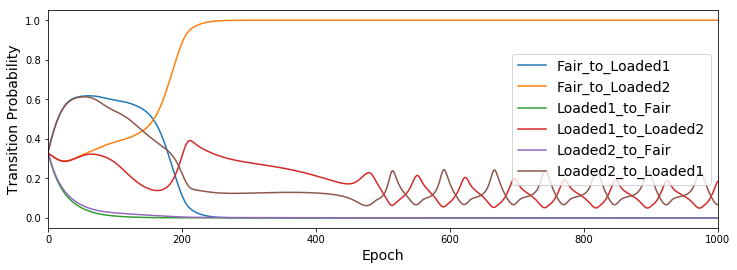

In [174]:
tprob_3d = pd.DataFrame({
    'Fair_to_Loaded1': [v[0,1] for (k,v) in transition_probs_3d.items()], 
    'Fair_to_Loaded2': [v[0,2] for (k,v) in transition_probs_3d.items()], 
    'Loaded1_to_Fair': [v[1,0] for (k,v) in transition_probs_3d.items()],
    'Loaded1_to_Loaded2': [v[1,2] for (k,v) in transition_probs_3d.items()],
    'Loaded2_to_Fair': [v[2,0] for (k,v) in transition_probs_3d.items()],
    'Loaded2_to_Loaded1': [v[2,1] for (k,v) in transition_probs_3d.items()]}) 
tprob_3d.plot(figsize=(12,4))
plt.ylabel('Transition Probability', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14);

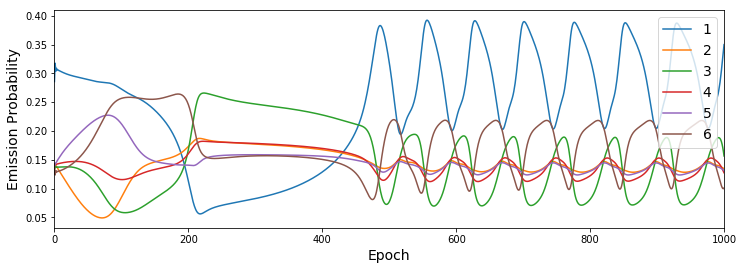

In [175]:
eprob_3d_1 = pd.DataFrame({
    1: [v[1,0] for (k,v) in emission_probs_3d.items()],
    2: [v[1,1] for (k,v) in emission_probs_3d.items()],
    3: [v[1,2] for (k,v) in emission_probs_3d.items()],
    4: [v[1,3] for (k,v) in emission_probs_3d.items()],    
    5: [v[1,4] for (k,v) in emission_probs_3d.items()],       
    6: [v[1,5] for (k,v) in emission_probs_3d.items()]})

eprob_3d_1.plot(kind='line', figsize=(12,4))
plt.ylabel('Emission Probability', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14);

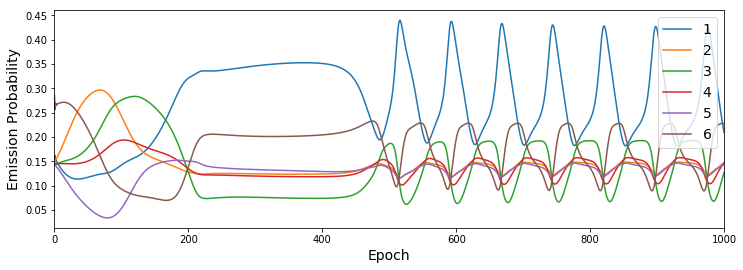

In [176]:
eprob_3d_2 = pd.DataFrame({
    1: [v[2,0] for (k,v) in emission_probs_3d.items()],
    2: [v[2,1] for (k,v) in emission_probs_3d.items()],
    3: [v[2,2] for (k,v) in emission_probs_3d.items()],
    4: [v[2,3] for (k,v) in emission_probs_3d.items()],    
    5: [v[2,4] for (k,v) in emission_probs_3d.items()],       
    6: [v[2,5] for (k,v) in emission_probs_3d.items()]})

eprob_3d_2.plot(kind='line', figsize=(12,4))
plt.ylabel('Emission Probability', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=14);

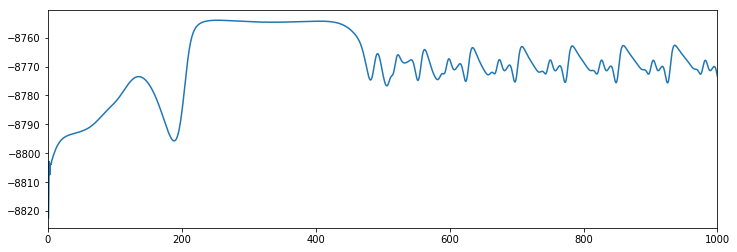

In [177]:
pd.Series(log_likelihoods_3d).plot(figsize=(12,4))

In [95]:
# # three dice - don't do this (need to break symmetry)
# A = np.array([[.34, .33, .33], 
#               [.33, .34, .33],
#               [.33, .33, .34]])
# B = np.array([[1./6, 1./6, 1./6, 1./6, 1./6, 1./6], 
#               [1./6, 1./6, 1./6, 1./6, 1./6, 1./6],
#               [1./6, 1./6, 1./6, 1./6, 1./6, 1./6]])
# initial_pi = np.array([1., 0., 0.])
# freeze_B = [True, False, False]

# model_3d = ModelHMM(A, B, data, freeze_B)
# transition_probs_3_dice, emission_probs_3d = model_3d.train(num_iter=200, initial_pi=initial_pi)
# print(model_3d.A)
# print(model_3d.B)

In [52]:
# import random
# fake_data1 = np.random.choice([1,1,1,1,1,2,3,4,5,6], size=2500)
# fake_data2 = np.random.choice([1,2,3,4,5,6], size=2500)
# fake_data = np.concatenate([fake_data1, fake_data2])
# random.shuffle(fake_data)